In [30]:
### Imports
# Standard library imports
import json
import os
import shutil
import logging
import sys

# Third-party imports
# Data handling
import numpy as np
import pandas as pd

# Image I/O and processing
import tifffile as tiff
from nd2reader import ND2Reader
from skimage.morphology import remove_small_objects

# Deep learning and segmentation
from csbdeep.utils import Path, normalize
from stardist import (
    fill_label_holes,
    random_label_cmap,
    calculate_extents,
    gputools_available,
)
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from tensorflow.keras.utils import Sequence

# Tracking
import btrack
from btrack.constants import BayesianUpdates

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm

from datetime import datetime

In [31]:
## Variables
## Directory Paths
# Input
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'
EXPERIMENT_INFO = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'
# Output
MASK_DIR = '../data/apo_masks'    # Stardist label predictions
CSV_DIR = '../data/apo_match_csv'    # File with manual and stardist centroids
DF_DIR = '../data/summary_dfs'
CROPS_DIR = '../data/apo_crops_test'    # Directory with .tif files for QC
WINDOWS_DIR = '/home/nbahou/myimaging/apoDet/data/windows_test'    # Directory with crops for scDINO
RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
CLASS_DCT_PATH = './extras/class_dicts'


## Processing Configuration
COMPARE_2D_VERS = True
SAVE_MASKS = True
LOAD_MASKS = True
USE_GPU = True
MIN_NUC_SIZE = 200

## Tracking Parameters
BT_CONFIG_FILE = "extras/cell_config.json"  # Path to btrack config file
EPS_TRACK = 70         # Tracking radius [px]
TRK_MIN_LEN = 25       # Minimum track length [frames]

#
MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want

WINDOW_SIZE = 61


## Logger Set Up
#logging.shutdown()    # For jupyter notebooks
logger = logging.getLogger(__name__)
#if logger.hasHandlers():
#    logger.handlers.clear()
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define log directory and ensure it exists
log_dir = "./logs"  # Folder for logs
os.makedirs(log_dir, exist_ok=True)  # Create directory if it doesn't exist

log_filename = f"cell_analysis_{timestamp}.log"
log_path = os.path.join(log_dir, log_filename)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler(sys.stdout)  # Outputs to console too
    ],
    force = True
)

# Create a logger instance
logger = logging.getLogger(__name__)

# Only forward Warnings/Errors/Critical from btrack
logging.getLogger('btrack').setLevel(logging.WARNING)


In [32]:
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)

def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
        logger.warning(f'\t\tWindow size even, adding 1. New window size: {window_size}')
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size + 1, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size + 1, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window
    

In [33]:
# Load image paths in specified directory
logger.info("Starting Image Processing")
image_paths = get_image_paths(os.path.join(IMG_DIR))
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths[:2]]    ### TODO remove :2 here, was only for testing
logger.info(f"Detected {len(filenames)} files in specified directories.")
#print(filenames)

# Create directories for saving if they do not exist
output_dirs = [CSV_DIR, MASK_DIR, DF_DIR, CROPS_DIR, CLASS_DCT_PATH, WINDOWS_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)

# Set up GT_mask prediction with stardist
if USE_GPU:
    import gputools
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)
model = StarDist2D.from_pretrained("2D_versatile_fluo")    # Load standard model to create GT
axis_norm = (0,1)    # for normalization

# Frame rate and movie length for crops
try:
    experiments_list = pd.read_csv(EXPERIMENT_INFO, header=0)
except FileNotFoundError as e:
    logger.critical(f"Critical error: experiment list file not found: {EXPERIMENT_INFO}. Aborting script.")
    sys.exit(1)
num_timepoints = MAX_TRACKING_DURATION // FRAME_INTERVAL    # eg 20mins/5min = 4 images. 

## Lists and counters for evaluation of the matching and cropping process
# Initialize list to collect distances between stardist and manual annotations for evaluation
dist_paolo_stardist = []
dist_alt_matching = []
# Initialize counter for evaluation of num matches/mismatches
num_matches = 0
num_mismatches = 0
# initalize a list to investigate track lengths after apoptosis
survival_times = []


# Loop over all files in target directory (predict labels, track and crop windows for each)
logger.info("Starting to process files.")
for path, filename in zip(image_paths, filenames):
    logger.info(f"Processing {filename}")
    # Skip file if not in experiment info csv
    experiment_num = filename.split('_')[0]
    matching_row = experiments_list[experiments_list['Experiment'] == experiment_num] 
    if matching_row.empty:
        logger.warning(f"\tExperiment {experiment_num} not found in the list. Skipping.")
        continue  # Skip this iteration
    # Skip file if specified interval between frames is not a multiple of that in input images
    acquisition_freq = matching_row['Acquisition_frequency(min)'].iloc[0]
    if FRAME_INTERVAL%acquisition_freq != 0:
        logger.warning(f"\tSkipping {filename}: {FRAME_INTERVAL} is not a multiple of {acquisition_freq}.")
        continue

    # Define step size to achieve target delta t between images
    step = FRAME_INTERVAL // acquisition_freq    # e.g. 5 // 1 = 1 image every 5 frames

    logger.debug(f"\tTime Info:")
    logger.debug(f"\t\t File Interval: {acquisition_freq} min/image")
    logger.debug(f"\t\tTarget Interval: {FRAME_INTERVAL} min/img")
    logger.debug(f"\t\tStep Size: {step}")
    logger.debug(f"\t\t Imgs in Crops: {num_timepoints} -> +1 for t0")

    # Create directory for cropped windows
    os.makedirs(os.path.join(CROPS_DIR, filename), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'no_apo_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'no_apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'random_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'random'), exist_ok=True)

    ### Stardist nuclei segmentation
    # Load and normalize image stack
    logger.info("\tStarting with Stardist segmentation.")
    h2b_imgs = load_image_stack(path) #[::step_size,:,:]
    h2b_imgs_normal = np.asarray([normalize(img,1,99.8,axis=axis_norm) for img in h2b_imgs])

    # Predict labels with pretrained stardist model
    gt = []    #--> lables
    details = []    # centroids and more
    for x in tqdm(h2b_imgs_normal):
        labels, det = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
        gt.append(labels)
        details.append(det)
    gt = np.asarray(gt)
    logger.info("\t\tSegmentation successful.")

    logger.info(f"\tRemoving objects smaller than {MIN_NUC_SIZE}.")
    # Remove small objects and create DF with segmentation info (object_id, t, x, y)
    gt_filtered = np.zeros_like(gt, dtype=np.uint16)
    num_frames = gt.shape[0]
    df_list = []
    for frame in range(num_frames):
        gt_filtered[frame] = remove_small_objects(
            gt[frame],
            min_size = MIN_NUC_SIZE
        )

        # Create DF after removing small objects
        unique_ids = np.unique(gt_filtered[frame])
        unique_ids = unique_ids[unique_ids > 0]    # Not interested in background ID
        x = []
        y = []
        timepoint = np.full_like(unique_ids, frame)

        current_details = details[frame]['points']    # --> centroids
        for obj_id in unique_ids:
            position = current_details[obj_id - 1]    # -1 because obj have 1 indexing, centroids start from 0
            x.append(position[1])
            y.append(position[0])

        d = {
            'obj_id': unique_ids,
            't': timepoint,
            'x': x,
            'y': y
        }
        current_df = pd.DataFrame(d)
        df_list.append(current_df)    # One df for every frame

    # Concatenate DFs for each t so we get one DF per file
    summary_df = pd.concat(df_list, ignore_index = True)
    logger.info("\t\tDone!")


    # Create btrack objects (with properties) from the segmentation data
    # By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
    # By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
    logger.info(f'\tStarting tracking for: {filename}')
    btObj = btrack.utils.segmentation_to_objects(
            gt_filtered, properties=("area",), assign_class_ID=True
    )
    _, fovY, fovX = gt_filtered.shape

    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config JSON file
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
    
        # append the objects to be tracked
        tracker.append(btObj)
    
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume = ((0, fovX), (0, fovY))
    
        # track them (in interactive mode)
        tracker.track(step_size=100)
    
        # generate hypotheses and run the global optimizer
        tracker.optimize()
    
        # get the tracks as a python list
        btTracks = tracker.tracks


    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)

    dfBTracks.rename(
        columns={
            "ID": "track_id",
            "t": "t",
            "x": "x",
            "y": "y",
            "class_id": "obj_id"
        }, inplace = True
    )

    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")
    logger.info("\t\tTracking Done.")

    logger.info("\tMerging information from Btrack and stardist.")
    merged_df = summary_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN].copy()
    logger.info("\t\tComplete.")

    ### Create a mask with btrack track_ids instead of stardists obj_ids
    logger.info("\tConverting Obj_IDs to Track_IDs in stardist masks.")
    # Create a list of lookup dicts for every timepoint
    mappings = []
    tracked_masks = np.zeros_like(gt_filtered)
    for t, mask_frame in enumerate(gt_filtered):
        current_df = merged_df[merged_df['t'] == t]
        # Set obj_id as index and only use track_id col --> obj_id as key, track_id as val
        obj_to_track = current_df.set_index('obj_id')['track_id'].to_dict()
        mappings.append(obj_to_track)
        
        for obj_id, track_id in obj_to_track.items():
            tracked_masks[t][mask_frame == obj_id] = track_id
            
    # Create dict with switched key value pairs (value becomes key)
    rev_mappings = []
    for obj_to_track in mappings:
        track_to_obj = {y: x for x, y in obj_to_track.items()}
        rev_mappings.append(track_to_obj)
    logger.info("\t\tDone!")


    ### Match manual and stardist annotations
    logger.info("\tMatching manual and stardist annotations")
    # Read CSV with manual apoptosis annotations 
    apo_file = os.path.join(APO_DIR, f'{filename}.csv')
    apo_annotations = pd.read_csv(apo_file, header=None, names=['filename', 'x', 'y', 't'])

    # Initialize lists to complete apo_annotations later
    delta_ts = []
    corresponding_objs = []
    corresponding_tracks = []
    strdst_x = []
    strdst_y = []
    for _, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        t, x, y = int(row['t']), int(row['x']), int(row['y'])
        centroids = details[t]['points']
        # Convert to NumPy array
        centroids = np.array(centroids)  # Shape: (N, 2)
        
        # Compute L2 norm (Euclidean distance), could be used for aleternative matching
        distances = np.linalg.norm(centroids - np.array([x, y]), axis=1)

        # At this point only here to compare performance to real matching
        match_index = np.argmin(distances)    
        match_centroid = centroids[match_index]
        #strdst_x.append(match_centroid[1])
        #strdst_y.append(match_centroid[0])
        alt_distance_to_paolo = distances[match_index]
        dist_alt_matching.append(alt_distance_to_paolo)

        
        # Perfect match
        if tracked_masks[t, y, x] != 0:
            corresponding_tracks.append(tracked_masks[t, y, x])
            corresponding_objs.append(gt_filtered[t, y, x])
            delta_ts.append(0)
            num_matches += 1
        # Also search previous and coming frames if position is background at time t
        else:
            t_start = max(0, t-3)
            t_end = min(t+3+1, tracked_masks.shape[0])
            previous_frames = tracked_masks[t_start:t_end, y, x]
            if previous_frames.size > 0:
                counts = np.bincount(previous_frames)
                match_id = np.argmax(counts)
            else:
                match_id = 0 

            if match_id == 0:
                num_mismatches += 1
            else:
                num_matches += 1
            
            for delta in [0, 1, -1, 2, -2, 3, -3]:
                if (t + delta) in range(t_start, t_end):
                    if tracked_masks[t + delta, y, x] == match_id:
                        corresponding_tracks.append(match_id)
                        corresponding_objs.append(gt_filtered[t + delta, y, x])
                        delta_ts.append(delta)
                        break
                            
        # Extract centroid of best matching object
        centroids = details[t + delta_ts[-1]]['points']
        match_centroid = centroids[corresponding_objs[-1]-1] if corresponding_objs[-1] > 0 else (9999, 9999)
        strdst_x.append(match_centroid[1])
        strdst_y.append(match_centroid[0])
        # Euclidean distance, used for plotting and validation
        distance_to_paolo = np.sqrt(((match_centroid[1]- row['x'])**2 + (match_centroid[0] - row['y'])**2))
        dist_paolo_stardist.append(distance_to_paolo)

    # Add object ID and centroids to apo annotation dataframe    
    apo_annotations['matching_object'] = corresponding_objs
    apo_annotations['matching_track'] = corresponding_tracks
    apo_annotations['strdst_x'] = strdst_x
    apo_annotations['strdst_y'] = strdst_y
    apo_annotations['delta_ts'] = delta_ts

    # Save again as CSV with added stardist centroids      
    apo_annotations.to_csv(os.path.join(CSV_DIR, f'{filename}.csv'), index=False)
    logger.info(f"\t\tApo-Annotations with stardist centroids saved at: {os.path.join(CSV_DIR, f'{filename}.csv')}")

    # Save summary df as CSV
    summary_df.to_csv(os.path.join(DF_DIR, f'{filename}_pd_df.csv'), index=False)
    logger.info(f"\t\tSummary-Df saved at: {os.path.join(DF_DIR, f'{filename}_pd_df.csv')}")
    
    # Save labels
    if SAVE_MASKS:
        mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
        np.savez_compressed(mask_path, gt=gt_filtered)
        logger.info(f"\t\tSummary-Df saved at: {mask_path}")
    logger.info("\t\tMatching finished.")


    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{filename}.tif'))
    
    # Counter so we can sample same amount of random tracks as apoptotic
    num_apo_crops = 0 

    # Vars for window cropping
    num_frames = MAX_TRACKING_DURATION // acquisition_freq
    target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1
    merged_df_long.loc[:, 'apoptotic'] = 0

    apo_track_ids = pd.DataFrame(columns=['track_id', 'apo_start_t'])

    logger.info("\tStarting cropping for apo cells")
    for i, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        current_track_id = row.loc['matching_track']
        current_t = row.loc['t'] + row.loc['delta_ts']

        apo_track_ids.loc[i, 'track_id'] = current_track_id
        apo_track_ids.loc[i, 'apo_start_t'] = current_t

        #current_track_id = current_track_id.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        if len(single_cell_df) < num_frames + 1:
            logger.warning(f"\t\tSkipping current track: {current_track_id}. Reason: Track lost too quickly after anno. len = {len(single_cell_df)}")
            continue
        
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        # merged_df_long.loc[single_cell_df.index, 'apoptotic'] = 1
        merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t), 'apoptotic'] = 1
        single_cell_df = single_cell_df.loc[single_cell_df['t'] < current_t + num_frames + step]
        
        
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)
            else:
                windows.append(None)


        chosen_offset = None
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):  
                chosen_offset = offset
                break  # Stop as soon as a valid sequence is found

        if chosen_offset is None:
            logger.warning("\t\tNo valid start point for a sequence with correct intervals found.")
        else:
            sub_windows = windows[chosen_offset::step]
            sub_windows = np.asarray(sub_windows)
            if len(sub_windows) == (MAX_TRACKING_DURATION // step) + 1:
                tiff.imwrite(os.path.join(CROPS_DIR, filename, f'trackID_{current_track_id}.tif'), sub_windows)
                tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{filename}_{i}.tif'), sub_windows)
                num_apo_crops += 1
            else:
                logger.warning(f'\t\tAt least one of the images has the wrong size after cropping and could not be used. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tValid crops of apo cells found for {num_apo_crops}/{len(apo_annotations)}")

    num_random_tracks = num_apo_crops
    
    logger.info('\tStarting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    num_healthy_crops = 0
    rejected_windows = 0

    for i, track_id in tqdm(enumerate(unique_track_ids), total=len(unique_track_ids), desc="Cropping non-apo Windows"):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == (MAX_TRACKING_DURATION) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{filename}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{filename}_{i}.tif'), windows[::step])
            num_healthy_crops += 1
        else:
            rejected_windows += 1

            logger.debug(f'\t\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tFound {num_healthy_crops} valid crops of healthy cells.")
    if rejected_windows > 0:
        logger.warning(f"\t\t{rejected_windows} windows were rejected due to incorrect size.")
    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    logger.info(f'\tStarting cropping for {num_random_tracks} random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape

    iter_count = 0
    crop_count = 0
    while (crop_count <= num_random_tracks) and (iter_count <= 100):    # Iter count only to stop runaway code
    # for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step):
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            track_id_mask_crop = crop_window(tracked_masks[t], random_x, random_y, WINDOW_SIZE)
            present_track_ids = track_id_mask_crop.flatten().tolist()
            

            ### Continue here
            current_apo_track_ids = apo_track_ids.loc[apo_track_ids['apo_start_t'] <= t]
            current_apo_ids = set(current_apo_track_ids['track_id'])

            
            if not any(pixel in current_apo_ids for pixel in present_track_ids) and (window.shape == (target_size, target_size)):
                windows.append(window)
            else:
                logger.warning("\t\tCurrent window contains an apoptotic cell or the shape is not matching the target size.")

    
        if len(windows) == (MAX_TRACKING_DURATION//FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{filename}', f'ID_{crop_count}.tif'), windows)
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'random', f'random_{filename}_{crop_count}.tif'), windows)
            crop_count += 1
            iter_count += 1
        else:
            logger.warning(f'\t\tUnable to collect the desired number of images. Length windows = {len(windows)}')
            iter_count += 1

    logger.info(f"Finished processing {filename}: apo ({num_apo_crops}), healthy ({num_healthy_crops}), random ({num_random_tracks})")

logging.shutdown()

2025-03-19 12:31:52,462 - __main__ - INFO - Starting Image Processing
2025-03-19 12:31:52,528 - __main__ - INFO - Detected 2 files in specified directories.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
2025-03-19 12:31:52,897 - __main__ - INFO - Starting to process files.
2025-03-19 12:31:52,899 - __main__ - INFO - Processing Exp01_Site01
2025-03-19 12:31:52,949 - __main__ - INFO - 	Starting with Stardist segmentation.


functional.py (237): The structure of `inputs` doesn't match the expected structure.           | 0/1441 [00:00<?, ?it/s]
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 1))
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [13:16<00:00,  1.81it/s]


2025-03-19 12:45:29,918 - __main__ - INFO - 		Segmentation successful.
2025-03-19 12:45:29,924 - __main__ - INFO - 	Removing objects smaller than 200.
2025-03-19 12:45:58,326 - __main__ - INFO - 		Done!
2025-03-19 12:45:58,327 - __main__ - INFO - 	Starting tracking for: Exp01_Site01


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:53<00:00, 12.65it/s]


GLPK Integer Optimizer 5.0
29796 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Preprocessing...
14898 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14898 rows, 28305 columns, 42923 non-zeros
*     0: obj =   8.451693242e+04 inf =   0.000e+00 (10678)
Perturbing LP to avoid stalling [511]...
*  8954: obj =   2.819904396e+04 inf =   2.000e-09 (1429) 5
Removing LP perturbation [10417]...
* 10417: obj =   2.708178225e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 10417: mip =     not found yet >=              -inf        (1; 0)
+ 10438: >>>>>   2.709167410e+04 >=   2.708690811e+04 < 0.1% (16; 0)
+ 10477: mip = 

Processing Annotations: 100%|█████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 7631.45it/s]

2025-03-19 12:50:02,402 - __main__ - INFO - 		Apo-Annotations with stardist centroids saved at: ../data/apo_match_csv/Exp01_Site01.csv


2025-03-19 12:50:02,867 - __main__ - INFO - 		Summary-Df saved at: ../data/summary_dfs/Exp01_Site01_pd_df.csv
2025-03-19 12:50:28,494 - __main__ - INFO - 		Summary-Df saved at: ../data/apo_masks/Exp01_Site01.npz
2025-03-19 12:50:28,497 - __main__ - INFO - 		Matching finished.
2025-03-19 12:50:30,412 - __main__ - INFO - 	Startign cropping for apo cells


Processing Annotations:   6%|███▌                                                        | 3/51 [00:00<00:01, 28.56it/s]

2025-03-19 12:50:30,577 - __main__ - WARNING - 		Skipping current track: 470. Reason: Track lost too quickly after anno. len = 2


Processing Annotations:  16%|█████████▍                                                  | 8/51 [00:00<00:01, 37.31it/s]

2025-03-19 12:50:30,663 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  25%|███████████████                                            | 13/51 [00:00<00:01, 37.20it/s]

2025-03-19 12:50:30,781 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  39%|███████████████████████▏                                   | 20/51 [00:00<00:00, 43.82it/s]

2025-03-19 12:50:30,989 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations: 100%|███████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.75it/s]

2025-03-19 12:50:32,563 - __main__ - INFO - 		Valid crops of apo cells found for 47/51
2025-03-19 12:50:32,564 - __main__ - INFO - 	Starting cropping for non-apo cells.



Cropping non-apo Windows: 100%|█████████████████████████████████████████████████████| 1115/1115 [00:17<00:00, 62.35it/s]

2025-03-19 12:50:50,502 - __main__ - INFO - 		Found 609 valid crops of healthy cells.
2025-03-19 12:50:50,502 - __main__ - WARNING - 		506 windows were rejected due to incorrect size.
2025-03-19 12:50:50,503 - __main__ - INFO - 	Starting cropping for 47 random locations.


2025-03-19 12:50:52,989 - __main__ - INFO - Finished processing Exp01_Site01: apo (47), healthy (609), random (47)
2025-03-19 12:50:52,990 - __main__ - INFO - Processing Exp01_Site02
2025-03-19 12:50:53,000 - __main__ - INFO - 	Starting with Stardist segmentation.


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [13:10<00:00,  1.82it/s]


2025-03-19 13:04:22,574 - __main__ - INFO - 		Segmentation successful.
2025-03-19 13:04:22,575 - __main__ - INFO - 	Removing objects smaller than 200.
2025-03-19 13:04:51,063 - __main__ - INFO - 		Done!
2025-03-19 13:04:51,064 - __main__ - INFO - 	Starting tracking for: Exp01_Site02


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:48<00:00, 13.29it/s]


GLPK Integer Optimizer 5.0
22416 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Preprocessing...
11208 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 11208
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
11208 rows, 20738 columns, 31011 non-zeros
*     0: obj =   5.898442483e+04 inf =   0.000e+00 (7433)
Perturbing LP to avoid stalling [557]...
Removing LP perturbation [7305]...
*  7305: obj =   1.977132116e+04 inf =   1.332e-15 (0) 5
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7305: mip =     not found yet >=              -inf        (1; 0)
+  7318: >>>>>   1.978664682e+04 >=   1.977801456e+04 < 0.1% (13; 0)
+  7362: mip =   1.978664682e+04 >=     tree is empty   0.0% (0; 45)
INTEGER 

Processing Annotations: 100%|█████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 4596.90it/s]

2025-03-19 13:08:41,462 - __main__ - INFO - 		Apo-Annotations with stardist centroids saved at: ../data/apo_match_csv/Exp01_Site02.csv


2025-03-19 13:08:41,951 - __main__ - INFO - 		Summary-Df saved at: ../data/summary_dfs/Exp01_Site02_pd_df.csv
2025-03-19 13:09:07,345 - __main__ - INFO - 		Summary-Df saved at: ../data/apo_masks/Exp01_Site02.npz
2025-03-19 13:09:07,349 - __main__ - INFO - 		Matching finished.
2025-03-19 13:09:08,563 - __main__ - INFO - 	Startign cropping for apo cells


Processing Annotations:   0%|                                                                    | 0/38 [00:00<?, ?it/s]

2025-03-19 13:09:08,603 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-19 13:09:08,605 - __main__ - WARNING - 		Skipping current track: 246. Reason: Track lost too quickly after anno. len = 18
2025-03-19 13:09:08,662 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  18%|███████████                                                 | 7/38 [00:00<00:00, 65.49it/s]

2025-03-19 13:09:08,894 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-19 13:09:08,902 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  37%|█████████████████████▋                                     | 14/38 [00:00<00:00, 36.12it/s]

2025-03-19 13:09:08,931 - __main__ - WARNING - 		Skipping current track: 1372. Reason: Track lost too quickly after anno. len = 11
2025-03-19 13:09:08,951 - __main__ - WARNING - 		Skipping current track: 223. Reason: Track lost too quickly after anno. len = 12
2025-03-19 13:09:08,971 - __main__ - WARNING - 		Skipping current track: 58. Reason: Track lost too quickly after anno. len = 16


Processing Annotations:  79%|██████████████████████████████████████████████▌            | 30/38 [00:00<00:00, 42.63it/s]

2025-03-19 13:09:09,332 - __main__ - WARNING - 		Skipping current track: 655. Reason: Track lost too quickly after anno. len = 11
2025-03-19 13:09:09,336 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations: 100%|███████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.57it/s]

2025-03-19 13:09:09,349 - __main__ - INFO - 		Valid crops of apo cells found for 28/38
2025-03-19 13:09:09,349 - __main__ - INFO - 	Starting cropping for non-apo cells.



Cropping non-apo Windows: 100%|███████████████████████████████████████████████████████| 894/894 [00:15<00:00, 59.41it/s]

2025-03-19 13:09:24,430 - __main__ - INFO - 		Found 457 valid crops of healthy cells.
2025-03-19 13:09:24,431 - __main__ - WARNING - 		437 windows were rejected due to incorrect size.
2025-03-19 13:09:24,431 - __main__ - INFO - 	Starting cropping for 28 random locations.


2025-03-19 13:09:26,084 - __main__ - INFO - Finished processing Exp01_Site02: apo (28), healthy (457), random (28)


### Rest

In [5]:
# Loop over all files in target directory
for path, filename in zip(image_paths, filenames):
    # Skip file if not in experiment info csv
    experiment_num = filename.split('_')[0]
    matching_row = experiments_list[experiments_list['Experiment'] == experiment_num] 
    if matching_row.empty:
        print(f"Warning: Experiment {experiment_num} not found in the list. Skipping.")
        continue  # Skip this iteration
    # Skip file if specified interval between frames is not a multiple of that in input images
    acquisition_freq = matching_row['Acquisition_frequency(min)'].iloc[0]
    if FRAME_INTERVAL%acquisition_freq != 0:
        print(f"Skipping {filename}: {FRAME_INTERVAL} is not a multiple of {acquisition_freq}.")
        continue
    step = FRAME_INTERVAL // acquisition_freq

    # Create directory for cropped windows
    os.makedirs(os.path.join(CROPS_DIR, filename), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'no_apo_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'no_apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'random_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'random'), exist_ok=True)

    
    # Load and normalize image stack
    h2b_imgs = load_image_stack(path) #[::step_size,:,:]
    h2b_imgs_normal = np.asarray([normalize(img,1,99.8,axis=axis_norm) for img in h2b_imgs])

    # Predict labels with pretrained stardist model
    gt = []    #--> lables
    details = []    # centroids and more
    for x in tqdm(h2b_imgs_normal):
        labels, det = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
        gt.append(labels)
        details.append(det)
    gt = np.asarray(gt)

         
    # Remove small objects and create DF with segmentation info (object_id, t, x, y)
    gt_filtered = np.zeros_like(gt, dtype=np.uint16)
    num_frames = gt.shape[0]
    df_list = []
    for frame in range(num_frames):
        gt_filtered[frame] = remove_small_objects(
            gt[frame],
            min_size = MIN_NUC_SIZE
        )

        # Create DF after removing small objects
        unique_ids = np.unique(gt_filtered[frame])
        unique_ids = unique_ids[unique_ids > 0]
        x = []
        y = []
        timepoint = np.full_like(unique_ids, frame)

        current_details = details[frame]['points']    # --> centroids
        for obj_id in unique_ids:
            position = current_details[obj_id - 1]    # -1 because obj have 1 indexing, centroids start from 0
            x.append(position[1])
            y.append(position[0])

        d = {
            'obj_id': unique_ids,
            't': timepoint,
            'x': x,
            'y': y
        }
        current_df = pd.DataFrame(d)
        df_list.append(current_df)

    # Concatenate DFs for each t so we get one DF per file
    summary_df = pd.concat(df_list, ignore_index = True)

functional.py (237): The structure of `inputs` doesn't match the expected structure.           | 0/1441 [00:00<?, ?it/s]
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
I0000 00:00:1742220729.837531 3728137 service.cc:148] XLA service 0x79f0f4005ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742220729.837559 3728137 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-17 15:12:09.856362: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742220729.920234 3728137 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742220730.860387 3728137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
functional.py (237): The structure of `inputs` doesn't match the expected structure.
Exp

In [47]:
for path, filename in zip(image_paths, filenames):
# Create btrack objects (with properties) from the segmentation data
    # By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
    # By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
    print(f'Starting tracking for: {filename}')
    btObj = btrack.utils.segmentation_to_objects(
            gt_filtered, properties=("area",), assign_class_ID=True
    )
    _, fovY, fovX = gt_filtered.shape

    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config JSON file
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
    
        # append the objects to be tracked
        tracker.append(btObj)
    
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume = ((0, fovX), (0, fovY))
    
        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)
    
        # generate hypotheses and run the global optimizer
        tracker.optimize()
    
        # get the tracks as a python list
        btTracks = tracker.tracks


    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)

    dfBTracks.rename(
        columns={
            "ID": "track_id",
            "t": "t",
            "x": "x",
            "y": "y",
            "class_id": "obj_id"
        }, inplace = True
    )

    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")

    print("\t Tracking done.\n")

    print("Start merging btrack output with stardist output.")
    merged_df = summary_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN]
    print("\tDone!\n")

    print("Converting Obj_IDs to Track_IDs in stardist masks.")
    mappings = []
    tracked_masks = np.zeros_like(gt_filtered)
    for t, mask_frame in enumerate(gt_filtered):
        current_df = merged_df[merged_df['t'] == t]
        obj_to_track = current_df.set_index('obj_id')['track_id'].to_dict()
        mappings.append(obj_to_track)
        
        for obj_id, track_id in obj_to_track.items():
            tracked_masks[t][mask_frame == obj_id] = track_id
            
    # Create dict with switched key value pairs (value becomes key)
    rev_mappings = []
    for obj_to_track in mappings:
        track_to_obj = {y: x for x, y in obj_to_track.items()}
        rev_mappings.append(track_to_obj)
    print("\tDone!\n")


    ## Match manual and stardist annotations
    print("Matching manual and stardist annotations")
    # Read CSV with manual apoptosis annotations 
    apo_file = os.path.join(APO_DIR, f'{filename}.csv')
    apo_annotations = pd.read_csv(apo_file, header=None, names=['filename', 'x', 'y', 't'])

    # Match handmade annotations with stardist detections
    delta_ts = []
    corresponding_objs = []
    corresponding_tracks = []
    strdst_x = []
    strdst_y = []
    for _, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        t, x, y = int(row['t']), int(row['x']), int(row['y'])
        centroids = details[t]['points']
        # Convert to NumPy array
        centroids = np.array(centroids)  # Shape: (N, 2)
        
        # Compute L2 norm (Euclidean distance)
        distances = np.linalg.norm(centroids - np.array([x, y]), axis=1)

        match_index = np.argmin(distances)    
        match_centroid = centroids[match_index]
        #strdst_x.append(match_centroid[1])
        #strdst_y.append(match_centroid[0])
        alt_distance_to_paolo = distances[match_index]
        dist_alt_matching.append(alt_distance_to_paolo)

        
        # Perfect match
        if tracked_masks[t, y, x] != 0:
            corresponding_tracks.append(tracked_masks[t, y, x])
            corresponding_objs.append(gt_filtered[t, y, x])
            delta_ts.append(0)
            num_matches += 1
        # Also search previous and coming frames if position is background at time t
        else:
            t_start = max(0, t-3)
            t_end = min(t+3+1, tracked_masks.shape[0])
            previous_frames = tracked_masks[t_start:t_end, y, x]
            if previous_frames.size > 0:
                counts = np.bincount(previous_frames)
                match_id = np.argmax(counts)
            else:
                match_id = 0 

            if match_id == 0:
                num_mismatches += 1
            else:
                num_matches += 1
            
            for delta in [0, 1, -1, 2, -2, 3, -3]:
                if (t + delta) in range(t_start, t_end):
                    if tracked_masks[t + delta, y, x] == match_id:
                        corresponding_tracks.append(match_id)
                        corresponding_objs.append(gt_filtered[t + delta, y, x])
                        delta_ts.append(delta)
                        break
                            
        # Extract centroid of best matching object
        centroids = details[t + delta_ts[-1]]['points']
        match_centroid = centroids[corresponding_objs[-1]-1] if corresponding_objs[-1] > 0 else (9999, 9999)
        strdst_x.append(match_centroid[1])
        strdst_y.append(match_centroid[0])
        # Euclidean distance, used for plotting and validation
        distance_to_paolo = np.sqrt(((match_centroid[1]- row['x'])**2 + (match_centroid[0] - row['y'])**2))
        dist_paolo_stardist.append(distance_to_paolo)

    # Add object ID and centroids to apo annotation dataframe    
    apo_annotations['matching_object'] = corresponding_objs
    apo_annotations['matching_track'] = corresponding_tracks
    apo_annotations['strdst_x'] = strdst_x
    apo_annotations['strdst_y'] = strdst_y
    apo_annotations['delta_ts'] = delta_ts

    # Save again as CSV with added stardist centroids      
    #apo_annotations.to_csv(os.path.join(CSV_DIR, f'{filename}.csv'), index=False)

    # Save summary df as CSV
    #summary_df.to_csv(os.path.join(DF_DIR, f'{filename}_pd_df.csv'), index=False)

    # Save labels
    #if SAVE_MASKS:
    #    mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
    #    np.savez_compressed(mask_path, gt=gt_filtered)
    print("\tMatching finished.\n")


    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{filename}.tif'))
    
    # Counter so we can sample same amount of random tracks as apoptotic
    num_random_tracks = 0 

    # Vars for window cropping
    num_frames = MAX_TRACKING_DURATION // acquisition_freq
    WINDOW_SIZE = 61
    target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1
    merged_df_long.loc[:, 'apoptotic'] = 0

    apo_track_ids = pd.DataFrame(columns=['track_id', 'apo_start_t'])
    
    print('Starting cropping for apo cells.')
    for i, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        current_track_id = row.loc['matching_track']
        current_t = row.loc['t'] + row.loc['delta_ts']

        apo_track_ids.loc[i, 'track_id'] = current_track_id
        apo_track_ids.loc[i, 'apo_start_t'] = current_t

        #current_track_id = current_track_id.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        if len(single_cell_df) < num_frames + 1:
            print(f"\tSkipping current track: {current_track_id}. Reason: Track lost too quickly after anno.")
            continue
        
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        # merged_df_long.loc[single_cell_df.index, 'apoptotic'] = 1
        merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t), 'apoptotic'] = 1
        single_cell_df = single_cell_df.loc[single_cell_df['t'] < current_t + num_frames + step]
        
        
        windows = []
        ### TODO: put to variables
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)
            else:
                windows.append(None)


        chosen_offset = None
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):  
                chosen_offset = offset
                break  # Stop as soon as a valid sequence is found

        if chosen_offset is None:
            print("No valid start point found.")
        else:
            sub_windows = windows[chosen_offset::step]
            sub_windows = np.asarray(sub_windows)
            if len(sub_windows) == (MAX_TRACKING_DURATION // step) + 1:
                tiff.imwrite(os.path.join(CROPS_DIR, filename, f'trackID_{current_track_id}.tif'), sub_windows)
                tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{filename}_{i}.tif'), sub_windows)
                num_random_tracks += 1
            else:
                print(f'\tAt least one of the images has the wrong size after cropping and could not be used. Length = {len(windows)}.')
            

    print('Starting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]

    
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    
    for i, track_id in tqdm(enumerate(unique_track_ids), total=len(unique_track_ids), desc="Cropping non-apo Windows"):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == (MAX_TRACKING_DURATION) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{filename}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{filename}_{i}.tif'), windows[::step])
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')

    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    ### TODO Check that no apoptotic cell is in window
    print('Starting cropping for random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape
    
    # Create a directory for random crops if needed
    RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
    os.makedirs(RANDOM_DIR, exist_ok=True)

    iter_count = 0
    crop_count = 0
    while (crop_count <= num_random_tracks) & (iter_count <= 100):    # Iter count only to stop runaway code
    # for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step):
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            track_id_mask_crop = crop_window(tracked_masks[t], random_x, random_y, WINDOW_SIZE)
            present_track_ids = track_id_mask_crop.flatten().tolist()
            

            ### Continue here
            current_apo_track_ids = apo_track_ids.loc[apo_track_ids['apo_start_t'] <= t]
            current_apo_ids = set(current_apo_track_ids['track_id'])

            
            if not any(pixel in current_apo_track_ids for pixel in present_track_ids) and (window.shape == (target_size, target_size)):
                windows.append(window)
            else:
                print(f"Frame {t}: Invalid window, skipping.")

            
            #if window.shape == (target_size, target_size):
            #    windows.append(window)
            #else:
            #    print(f"Frame {t}: Invalid window, skipping.")
    
        if len(windows) == (MAX_TRACKING_DURATION//FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{filename}', f'ID_{crop_count}.tif'), windows)
            tiff.imwrite(os.path.join(RANDOM_DIR, f'random_{filename}_{crop_count}.tif'), windows)
            crop_count += 1
            iter_count += 1
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}')
            iter_count += 1

[INFO][2025/03/17 04:38:29 PM] Localizing objects from segmentation...
INFO:btrack.io._localization | Localizing objects from segmentation...


Starting tracking for: Exp01_Site01


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:46<00:00, 13.57it/s]
[INFO][2025/03/17 04:40:15 PM] Objects are of type: <class 'dict'>
INFO:btrack.io.utils | Objects are of type: <class 'dict'>
[INFO][2025/03/17 04:40:19 PM] ...Found 612856 objects in 1441 frames.
INFO:btrack.io._localization | ...Found 612856 objects in 1441 frames.
[INFO][2025/03/17 04:40:19 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
INFO:btrack.libwrapper | Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/17 04:40:19 PM] Starting BayesianTracker session
INFO:btrack.core | Starting BayesianTracker session
[INFO][2025/03/17 04:40:19 PM] Loading configuration file: extras/cell_config.json
INFO:btrack.config | Loading configuration file: extras/cell_config.json
[INFO][2025/03/17 04:40:19 PM] Objects are of type: <class 'list'>
IN

GLPK Integer Optimizer 5.0
29796 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Preprocessing...
14898 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14898 rows, 28305 columns, 42923 non-zeros
*     0: obj =   8.451693242e+04 inf =   0.000e+00 (10678)
Perturbing LP to avoid stalling [511]...
*  8968: obj =   2.817981991e+04 inf =   2.000e-09 (1410) 5
Removing LP perturbation [10417]...
* 10417: obj =   2.708178225e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 10417: mip =     not found yet >=              -inf        (1; 0)
+ 10438: >>>>>   2.709167410e+04 >=   2.708690811e+04 < 0.1% (16; 0)
+ 10477: mip = 

[INFO][2025/03/17 04:40:36 PM] Completed optimization with 4929 tracks
INFO:btrack.core | Completed optimization with 4929 tracks
[INFO][2025/03/17 04:40:37 PM] Ending BayesianTracker session
INFO:btrack.core | Ending BayesianTracker session


	 Tracking done.

Start merging btrack output with stardist output.
	Done!

Converting Obj_IDs to Track_IDs in stardist masks.
	Done!

Matching manual and stardist annotations


Processing Annotations: 100%|█████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 7357.16it/s]

	Matching finished.




1237419405.py (171): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting cropping for apo cells.


Processing Annotations:  18%|██████████▌                                                 | 9/51 [00:00<00:00, 87.18it/s]

	Skipping current track: 470. Reason: Track lost too quickly after anno.
No valid start point found.
No valid start point found.


Processing Annotations:  37%|█████████████████████▉                                     | 19/51 [00:00<00:00, 92.20it/s]

No valid start point found.


Processing Annotations: 100%|███████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 88.35it/s]


Starting cropping for non-apo cells.


Cropping non-apo Windows:   1%|▌                                                     | 11/1115 [00:00<00:10, 101.48it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 1006, 666.
	At least one of the images has the wrong size. Length = 0. Pos = 10, 654.


Cropping non-apo Windows:   4%|██▏                                                   | 45/1115 [00:00<00:10, 105.05it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 24, 734.
	At least one of the images has the wrong size. Length = 0. Pos = 1014, 728.
	At least one of the images has the wrong size. Length = 0. Pos = 18, 690.
	At least one of the images has the wrong size. Length = 0. Pos = 996, 560.


Cropping non-apo Windows:   7%|███▉                                                  | 81/1115 [00:00<00:09, 110.69it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 4, 524.
	At least one of the images has the wrong size. Length = 0. Pos = 1008, 506.
	At least one of the images has the wrong size. Length = 0. Pos = 8, 622.


Cropping non-apo Windows:   9%|████▉                                                | 105/1115 [00:00<00:09, 108.85it/s]

	At least one of the images has the wrong size. Length = 1. Pos = 24, 576.
	At least one of the images has the wrong size. Length = 17. Pos = 990, 916.


Cropping non-apo Windows:  14%|███████▏                                             | 151/1115 [00:01<00:07, 135.38it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 10, 894.
	At least one of the images has the wrong size. Length = 0. Pos = 1010, 888.
	At least one of the images has the wrong size. Length = 0. Pos = 12, 988.
	At least one of the images has the wrong size. Length = 0. Pos = 16, 1014.
	At least one of the images has the wrong size. Length = 0. Pos = 974, 1006.
	At least one of the images has the wrong size. Length = 0. Pos = 454, 1010.
	At least one of the images has the wrong size. Length = 0. Pos = 686, 1008.
	At least one of the images has the wrong size. Length = 0. Pos = 930, 994.
	At least one of the images has the wrong size. Length = 0. Pos = 826, 1000.
	At least one of the images has the wrong size. Length = 0. Pos = 246, 1002.
	At least one of the images has the wrong size. Length = 0. Pos = 416, 994.
	At least one of the images has the wrong size. Length = 3. Pos = 614, 992.
	At least one of the images has the wrong size. Length = 5. Pos = 150, 992.
	At leas

Cropping non-apo Windows:  17%|█████████                                            | 190/1115 [00:01<00:08, 113.13it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 372, 760.
	At least one of the images has the wrong size. Length = 0. Pos = 14, 854.
	At least one of the images has the wrong size. Length = 0. Pos = 66, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 1010, 838.


Cropping non-apo Windows:  19%|██████████▏                                          | 215/1115 [00:01<00:08, 110.17it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 8, 196.
	At least one of the images has the wrong size. Length = 0. Pos = 998, 190.
	At least one of the images has the wrong size. Length = 20. Pos = 460, 176.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 140.
	At least one of the images has the wrong size. Length = 0. Pos = 8, 140.


Cropping non-apo Windows:  24%|████████████▉                                        | 272/1115 [00:02<00:06, 132.15it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 670, 16.
	At least one of the images has the wrong size. Length = 19. Pos = 838, 28.
	At least one of the images has the wrong size. Length = 18. Pos = 282, 28.
	At least one of the images has the wrong size. Length = 0. Pos = 888, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 16, 72.
	At least one of the images has the wrong size. Length = 0. Pos = 802, 12.
	At least one of the images has the wrong size. Length = 0. Pos = 968, 14.
	At least one of the images has the wrong size. Length = 0. Pos = 928, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 760, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 720, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 560, 16.
	At least one of the images has the wrong size. Length = 0. Pos = 506, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 442, 4.
	At least one of the images ha

Cropping non-apo Windows:  26%|█████████████▌                                       | 286/1115 [00:02<00:06, 120.10it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 1018, 110.


Cropping non-apo Windows:  28%|██████████████▊                                      | 311/1115 [00:02<00:07, 106.39it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 1008, 440.
	At least one of the images has the wrong size. Length = 10. Pos = 26, 408.


Cropping non-apo Windows:  31%|████████████████▎                                    | 344/1115 [00:03<00:07, 105.54it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 12, 480.
	At least one of the images has the wrong size. Length = 0. Pos = 8, 450.


Cropping non-apo Windows:  34%|█████████████████▉                                   | 377/1115 [00:03<00:07, 102.92it/s]

	At least one of the images has the wrong size. Length = 12. Pos = 998, 302.
	At least one of the images has the wrong size. Length = 0. Pos = 1002, 348.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 342.


Cropping non-apo Windows:  38%|███████████████████▉                                 | 419/1115 [00:03<00:05, 125.93it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 1018, 600.
	At least one of the images has the wrong size. Length = 0. Pos = 188, 1016.
	At least one of the images has the wrong size. Length = 0. Pos = 840, 4.
	At least one of the images has the wrong size. Length = 8. Pos = 76, 986.
	At least one of the images has the wrong size. Length = 19. Pos = 968, 710.
	At least one of the images has the wrong size. Length = 3. Pos = 1000, 796.
	At least one of the images has the wrong size. Length = 0. Pos = 374, 4.
	At least one of the images has the wrong size. Length = 20. Pos = 376, 246.
	At least one of the images has the wrong size. Length = 20. Pos = 378, 210.
	At least one of the images has the wrong size. Length = 19. Pos = 854, 84.
	At least one of the images has the wrong size. Length = 20. Pos = 862, 60.
	At least one of the images has the wrong size. Length = 19. Pos = 956, 878.
	At least one of the images has the wrong size. Length = 0. Pos = 1004, 408.
	At least

Cropping non-apo Windows:  42%|██████████████████████                               | 463/1115 [00:03<00:03, 168.48it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 640, 314.
	At least one of the images has the wrong size. Length = 20. Pos = 660, 520.
	At least one of the images has the wrong size. Length = 0. Pos = 1006, 794.
	At least one of the images has the wrong size. Length = 19. Pos = 254, 870.
	At least one of the images has the wrong size. Length = 0. Pos = 282, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 554.
	At least one of the images has the wrong size. Length = 0. Pos = 472, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 52, 794.
	At least one of the images has the wrong size. Length = 20. Pos = 968, 724.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 46.
	At least one of the images has the wrong size. Length = 20. Pos = 60, 612.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 768.
	At least one of the images has the wrong size. Length = 20. Pos = 712, 100.
	A

Cropping non-apo Windows:  45%|███████████████████████▉                             | 504/1115 [00:04<00:03, 180.76it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 852, 72.
	At least one of the images has the wrong size. Length = 20. Pos = 324, 82.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 952.
	At least one of the images has the wrong size. Length = 0. Pos = 70, 1016.
	At least one of the images has the wrong size. Length = 0. Pos = 38, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 740, 4.
	At least one of the images has the wrong size. Length = 19. Pos = 606, 712.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 50.
	At least one of the images has the wrong size. Length = 20. Pos = 712, 476.
	At least one of the images has the wrong size. Length = 0. Pos = 30, 1008.
	At least one of the images has the wrong size. Length = 0. Pos = 792, 4.
	At least one of the images has the wrong size. Length = 18. Pos = 746, 96.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 1014.
	At least one 

Cropping non-apo Windows:  49%|█████████████████████████▊                           | 543/1115 [00:04<00:03, 183.62it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 658, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 730, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 594, 796.
	At least one of the images has the wrong size. Length = 0. Pos = 150, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 878.
	At least one of the images has the wrong size. Length = 18. Pos = 784, 624.
	At least one of the images has the wrong size. Length = 0. Pos = 28, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 622, 216.
	At least one of the images has the wrong size. Length = 0. Pos = 28, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 782.
	At least one of the images has the wrong size. Length = 20. Pos = 54, 700.
	At least one of the images has the wrong size. Length = 19. Pos = 910, 416.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 892.
	At l

Cropping non-apo Windows:  51%|██████████████████████████▉                          | 567/1115 [00:04<00:02, 196.60it/s]

	At least one of the images has the wrong size. Length = 19. Pos = 778, 230.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 490.
	At least one of the images has the wrong size. Length = 19. Pos = 910, 414.
	At least one of the images has the wrong size. Length = 19. Pos = 158, 646.
	At least one of the images has the wrong size. Length = 19. Pos = 982, 838.
	At least one of the images has the wrong size. Length = 19. Pos = 826, 794.
	At least one of the images has the wrong size. Length = 19. Pos = 78, 704.
	At least one of the images has the wrong size. Length = 0. Pos = 482, 1018.
	At least one of the images has the wrong size. Length = 3. Pos = 28, 708.
	At least one of the images has the wrong size. Length = 0. Pos = 366, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 740.
	At least one of the images has the wrong size. Length = 20. Pos = 922, 426.
	At least one of the images has the wrong size. Length = 20. Pos = 852, 554.
	At l

Cropping non-apo Windows:  54%|████████████████████████████▊                        | 606/1115 [00:04<00:02, 176.42it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 62, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 772, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 334, 848.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 112.
	At least one of the images has the wrong size. Length = 0. Pos = 594, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 932, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 432, 1016.
	At least one of the images has the wrong size. Length = 20. Pos = 618, 688.
	At least one of the images has the wrong size. Length = 0. Pos = 782, 4.
	At least one of the images has the wrong size. Length = 20. Pos = 822, 532.
	At least one of the images has the wrong size. Length = 0. Pos = 138, 4.
	At least one of the images has the wrong size. Length = 16. Pos = 742, 366.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 848.
	At le

Cropping non-apo Windows:  59%|███████████████████████████████                      | 653/1115 [00:04<00:02, 198.68it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 852, 72.
	At least one of the images has the wrong size. Length = 20. Pos = 590, 588.
	At least one of the images has the wrong size. Length = 0. Pos = 42, 4.
	At least one of the images has the wrong size. Length = 19. Pos = 666, 60.
	At least one of the images has the wrong size. Length = 19. Pos = 760, 328.
	At least one of the images has the wrong size. Length = 17. Pos = 30, 618.
	At least one of the images has the wrong size. Length = 20. Pos = 316, 64.
	At least one of the images has the wrong size. Length = 20. Pos = 700, 582.
	At least one of the images has the wrong size. Length = 20. Pos = 702, 458.
	At least one of the images has the wrong size. Length = 0. Pos = 278, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 1004, 772.
	At least one of the images has the wrong size. Length = 19. Pos = 164, 84.
	At least one of the images has the wrong size. Length = 19. Pos = 622, 700.
	At leas

Cropping non-apo Windows:  63%|█████████████████████████████████▏                   | 698/1115 [00:05<00:02, 195.73it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 892, 896.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 836.
	At least one of the images has the wrong size. Length = 20. Pos = 358, 74.
	At least one of the images has the wrong size. Length = 0. Pos = 1012, 584.
	At least one of the images has the wrong size. Length = 20. Pos = 614, 692.
	At least one of the images has the wrong size. Length = 0. Pos = 28, 900.
	At least one of the images has the wrong size. Length = 20. Pos = 768, 352.
	At least one of the images has the wrong size. Length = 19. Pos = 310, 46.
	At least one of the images has the wrong size. Length = 19. Pos = 34, 950.
	At least one of the images has the wrong size. Length = 0. Pos = 778, 4.
	At least one of the images has the wrong size. Length = 20. Pos = 758, 372.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 748.
	At least one of the images has the wrong size. Length = 20. Pos = 874, 448.
	At least 

Cropping non-apo Windows:  67%|███████████████████████████████████▎                 | 744/1115 [00:05<00:01, 192.62it/s]

	At least one of the images has the wrong size. Length = 18. Pos = 764, 378.
	At least one of the images has the wrong size. Length = 20. Pos = 136, 278.
	At least one of the images has the wrong size. Length = 19. Pos = 666, 90.
	At least one of the images has the wrong size. Length = 18. Pos = 706, 98.
	At least one of the images has the wrong size. Length = 19. Pos = 172, 88.
	At least one of the images has the wrong size. Length = 0. Pos = 776, 1012.
	At least one of the images has the wrong size. Length = 19. Pos = 876, 42.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 308.
	At least one of the images has the wrong size. Length = 0. Pos = 346, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 106.
	At least one of the images has the wrong size. Length = 20. Pos = 268, 238.
	At least one of the images has the wrong size. Length = 18. Pos = 886, 80.
	At least one of the images has the wrong size. Length = 19. Pos = 896, 42.
	At leas

Cropping non-apo Windows:  70%|█████████████████████████████████████▎               | 784/1115 [00:05<00:01, 191.30it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 262, 214.
	At least one of the images has the wrong size. Length = 20. Pos = 290, 216.
	At least one of the images has the wrong size. Length = 19. Pos = 922, 448.
	At least one of the images has the wrong size. Length = 18. Pos = 810, 536.
	At least one of the images has the wrong size. Length = 0. Pos = 242, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 640, 828.
	At least one of the images has the wrong size. Length = 0. Pos = 66, 4.
	At least one of the images has the wrong size. Length = 20. Pos = 730, 364.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 408.
	At least one of the images has the wrong size. Length = 20. Pos = 170, 870.
	At least one of the images has the wrong size. Length = 0. Pos = 144, 1018.
	At least one of the images has the wrong size. Length = 17. Pos = 134, 622.
	At least one of the images has the wrong size. Length = 18. Pos = 40, 710.
	At 

Cropping non-apo Windows:  75%|███████████████████████████████████████▋             | 836/1115 [00:05<00:01, 221.38it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 770, 930.
	At least one of the images has the wrong size. Length = 18. Pos = 836, 74.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 420.
	At least one of the images has the wrong size. Length = 2. Pos = 834, 22.
	At least one of the images has the wrong size. Length = 0. Pos = 860, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 96, 798.
	At least one of the images has the wrong size. Length = 19. Pos = 298, 58.
	At least one of the images has the wrong size. Length = 20. Pos = 304, 950.
	At least one of the images has the wrong size. Length = 19. Pos = 680, 498.
	At least one of the images has the wrong size. Length = 0. Pos = 420, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 740, 1010.
	At least one of the images has the wrong size. Length = 19. Pos = 184, 118.
	At least one of the images has the wrong size. Length = 20. Pos = 662, 62.
	At l

Cropping non-apo Windows:  78%|█████████████████████████████████████████▎           | 868/1115 [00:05<00:01, 243.55it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 812, 4.
	At least one of the images has the wrong size. Length = 17. Pos = 838, 66.
	At least one of the images has the wrong size. Length = 0. Pos = 460, 1014.
	At least one of the images has the wrong size. Length = 18. Pos = 254, 410.
	At least one of the images has the wrong size. Length = 19. Pos = 602, 478.
	At least one of the images has the wrong size. Length = 0. Pos = 142, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 942, 820.
	At least one of the images has the wrong size. Length = 20. Pos = 308, 48.
	At least one of the images has the wrong size. Length = 0. Pos = 162, 20.
	At least one of the images has the wrong size. Length = 0. Pos = 1012, 858.
	At least one of the images has the wrong size. Length = 20. Pos = 376, 178.
	At least one of the images has the wrong size. Length = 19. Pos = 346, 164.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 420.
	At least

Cropping non-apo Windows:  82%|███████████████████████████████████████████▌         | 916/1115 [00:06<00:00, 213.59it/s]

	At least one of the images has the wrong size. Length = 19. Pos = 650, 660.
	At least one of the images has the wrong size. Length = 19. Pos = 510, 554.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 56.
	At least one of the images has the wrong size. Length = 20. Pos = 700, 236.
	At least one of the images has the wrong size. Length = 0. Pos = 148, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 166, 88.
	At least one of the images has the wrong size. Length = 0. Pos = 488, 1018.
	At least one of the images has the wrong size. Length = 20. Pos = 88, 314.
	At least one of the images has the wrong size. Length = 19. Pos = 670, 472.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 134.
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 424.
	At least one of the images has the wrong size. Length = 19. Pos = 852, 746.
	At least one of the images has the wrong size. Length = 18. Pos = 162, 734.
	At l

Cropping non-apo Windows:  87%|██████████████████████████████████████████████▎      | 974/1115 [00:06<00:00, 241.93it/s]

	At least one of the images has the wrong size. Length = 19. Pos = 582, 472.
	At least one of the images has the wrong size. Length = 19. Pos = 404, 760.
	At least one of the images has the wrong size. Length = 0. Pos = 214, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 58, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 962, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 18, 848.
	At least one of the images has the wrong size. Length = 19. Pos = 708, 120.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 280.
	At least one of the images has the wrong size. Length = 0. Pos = 966, 4.
	At least one of the images has the wrong size. Length = 0. Pos = 348, 1004.
	At least one of the images has the wrong size. Length = 19. Pos = 940, 262.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 322.
	At least one of the images has the wrong size. Length = 19. Pos = 496, 142.
	At leas

Cropping non-apo Windows:  92%|███████████████████████████████████████████████▋    | 1023/1115 [00:06<00:00, 221.16it/s]

	At least one of the images has the wrong size. Length = 0. Pos = 10, 844.
	At least one of the images has the wrong size. Length = 20. Pos = 254, 378.
	At least one of the images has the wrong size. Length = 19. Pos = 544, 890.
	At least one of the images has the wrong size. Length = 11. Pos = 472, 992.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 58.
	At least one of the images has the wrong size. Length = 19. Pos = 268, 540.
	At least one of the images has the wrong size. Length = 19. Pos = 760, 536.
	At least one of the images has the wrong size. Length = 6. Pos = 34, 720.
	At least one of the images has the wrong size. Length = 16. Pos = 452, 982.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 502.
	At least one of the images has the wrong size. Length = 0. Pos = 382, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 764, 1018.
	At least one of the images has the wrong size. Length = 13. Pos = 474, 992.
	At 

Cropping non-apo Windows:  96%|█████████████████████████████████████████████████▊  | 1068/1115 [00:06<00:00, 198.05it/s]

	At least one of the images has the wrong size. Length = 19. Pos = 342, 544.
	At least one of the images has the wrong size. Length = 19. Pos = 308, 694.
	At least one of the images has the wrong size. Length = 20. Pos = 182, 784.
	At least one of the images has the wrong size. Length = 19. Pos = 260, 404.
	At least one of the images has the wrong size. Length = 0. Pos = 12, 744.
	At least one of the images has the wrong size. Length = 20. Pos = 662, 480.
	At least one of the images has the wrong size. Length = 20. Pos = 84, 800.
	At least one of the images has the wrong size. Length = 19. Pos = 620, 346.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 508.
	At least one of the images has the wrong size. Length = 20. Pos = 302, 586.
	At least one of the images has the wrong size. Length = 18. Pos = 290, 184.
	At least one of the images has the wrong size. Length = 20. Pos = 378, 154.
	At least one of the images has the wrong size. Length = 19. Pos = 262, 374.
	A

Cropping non-apo Windows: 100%|████████████████████████████████████████████████████| 1115/1115 [00:07<00:00, 157.10it/s]

	At least one of the images has the wrong size. Length = 20. Pos = 434, 606.
	At least one of the images has the wrong size. Length = 20. Pos = 258, 60.
	At least one of the images has the wrong size. Length = 18. Pos = 964, 292.
	At least one of the images has the wrong size. Length = 17. Pos = 82, 606.
	At least one of the images has the wrong size. Length = 20. Pos = 362, 592.
	At least one of the images has the wrong size. Length = 0. Pos = 1004, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 380, 1018.
	At least one of the images has the wrong size. Length = 0. Pos = 24, 68.
	At least one of the images has the wrong size. Length = 20. Pos = 856, 778.
	At least one of the images has the wrong size. Length = 16. Pos = 398, 746.
	At least one of the images has the wrong size. Length = 20. Pos = 300, 688.
	At least one of the images has the wrong size. Length = 19. Pos = 308, 602.
	At least one of the images has the wrong size. Length = 20. Pos = 166, 716.
	At

### First all in one approach

In [34]:
image_paths = get_image_paths(os.path.join(IMG_DIR))

### TODO remove :2 here, was only for testing
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths[:1]]
print(filenames)

# Create directories for saving if they do not exist
output_dirs = [CSV_DIR, MASK_DIR, DF_DIR, CROPS_DIR, CLASS_DCT_PATH, WINDOWS_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)

# Set up GT_mask prediction with stardist
if USE_GPU:
    import gputools
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)

model = StarDist2D.from_pretrained("2D_versatile_fluo")    # Load standard model to create GT
axis_norm = (0,1)    # for normalization

# Frame rate and movie length for crops
experiments_list = pd.read_csv(EXPERIMENT_INFO, header=0)
MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want
num_timepoints = MAX_TRACKING_DURATION // FRAME_INTERVAL






# Initialize list to collect distances between stardist and manual annotations
dist_paolo_stardist = []
dist_alt_matching = []

num_matches = 0
num_mismatches = 0

# initalize a list to investigate track lengths after apoptosis
survival_times = []

# Loop over all files in target directory
for path, filename in zip(image_paths, filenames):
    # Skip file if not in experiment info csv
    experiment_num = filename.split('_')[0]
    matching_row = experiments_list[experiments_list['Experiment'] == experiment_num] 
    if matching_row.empty:
        print(f"Warning: Experiment {experiment_num} not found in the list. Skipping.")
        continue  # Skip this iteration
    # Skip file if specified interval between frames is not a multiple of that in input images
    acquisition_freq = matching_row['Acquisition_frequency(min)'].iloc[0]
    if FRAME_INTERVAL%acquisition_freq != 0:
        print(f"Skipping {filename}: {FRAME_INTERVAL} is not a multiple of {acquisition_freq}.")
        continue
    step = FRAME_INTERVAL // acquisition_freq

    # Create directory for cropped windows
    os.makedirs(os.path.join(CROPS_DIR, filename), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'no_apo_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'no_apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'random_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'random'), exist_ok=True)

    
    # Load and normalize image stack
    h2b_imgs = load_image_stack(path) #[::step_size,:,:]
    h2b_imgs_normal = np.asarray([normalize(img,1,99.8,axis=axis_norm) for img in h2b_imgs])

    # Predict labels with pretrained stardist model
    gt = []    #--> lables
    details = []    # centroids and more
    for x in tqdm(h2b_imgs_normal):
        labels, det = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
        gt.append(labels)
        details.append(det)
    gt = np.asarray(gt)

         
    # Remove small objects and create DF with segmentation info (object_id, t, x, y)
    gt_filtered = np.zeros_like(gt, dtype=np.uint16)
    num_frames = gt.shape[0]
    df_list = []
    for frame in range(num_frames):
        gt_filtered[frame] = remove_small_objects(
            gt[frame],
            min_size = MIN_NUC_SIZE
        )

        # Create DF after removing small objects
        unique_ids = np.unique(gt_filtered[frame])
        unique_ids = unique_ids[unique_ids > 0]
        x = []
        y = []
        timepoint = np.full_like(unique_ids, frame)

        current_details = details[frame]['points']    # --> centroids
        for obj_id in unique_ids:
            position = current_details[obj_id - 1]    # -1 because obj have 1 indexing, centroids start from 0
            x.append(position[1])
            y.append(position[0])

        d = {
            'obj_id': unique_ids,
            't': timepoint,
            'x': x,
            'y': y
        }
        current_df = pd.DataFrame(d)
        df_list.append(current_df)

    # Concatenate DFs for each t so we get one DF per file
    summary_df = pd.concat(df_list, ignore_index = True)


    # Create btrack objects (with properties) from the segmentation data
    # By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
    # By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
    btObj = btrack.utils.segmentation_to_objects(
            gt_filtered, properties=("area",), assign_class_ID=True
    )
    _, fovY, fovX = gt_filtered.shape

    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config JSON file
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
    
        # append the objects to be tracked
        tracker.append(btObj)
    
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume = ((0, fovX), (0, fovY))
    
        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)
    
        # generate hypotheses and run the global optimizer
        tracker.optimize()
    
        # get the tracks as a python list
        btTracks = tracker.tracks


    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)

    dfBTracks.rename(
        columns={
            "ID": "track_id",
            "t": "t",
            "x": "x",
            "y": "y",
            "class_id": "obj_id"
        }, inplace = True
    )

    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")

    merged_df = summary_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN]

    mappings = []
    tracked_masks = np.zeros_like(gt_filtered)
    for t, mask_frame in enumerate(gt_filtered):
        current_df = merged_df[merged_df['t'] == t]
        obj_to_track = current_df.set_index('obj_id')['track_id'].to_dict()
        mappings.append(obj_to_track)
        
        for obj_id, track_id in obj_to_track.items():
            tracked_masks[t][mask_frame == obj_id] = track_id
            
    # Create dict with switched key value pairs (value becomes key)
    rev_mappings = []
    for obj_to_track in mappings:
        track_to_obj = {y: x for x, y in obj_to_track.items()}
        rev_mappings.append(track_to_obj)


    ## Match manual and stardist annotations
    # Read CSV with manual apoptosis annotations 
    apo_file = os.path.join(APO_DIR, f'{filename}.csv')
    apo_annotations = pd.read_csv(apo_file, header=None, names=['filename', 'x', 'y', 't'])

    # Match handmade annotations with stardist detections
    delta_ts = []
    corresponding_objs = []
    corresponding_tracks = []
    strdst_x = []
    strdst_y = []
    for _, row in apo_annotations.iterrows():
        t, x, y = int(row['t']), int(row['x']), int(row['y'])
        centroids = details[t]['points']
        # Convert to NumPy array
        centroids = np.array(centroids)  # Shape: (N, 2)
        
        # Compute L2 norm (Euclidean distance)
        distances = np.linalg.norm(centroids - np.array([x, y]), axis=1)

        match_index = np.argmin(distances)    
        match_centroid = centroids[match_index]
        #strdst_x.append(match_centroid[1])
        #strdst_y.append(match_centroid[0])
        alt_distance_to_paolo = distances[match_index]
        dist_alt_matching.append(alt_distance_to_paolo)

        
        # Perfect match
        if tracked_masks[t, y, x] != 0:
            corresponding_tracks.append(tracked_masks[t, y, x])
            corresponding_objs.append(gt_filtered[t, y, x])
            delta_ts.append(0)
            num_matches += 1
        # Also search previous and coming frames if position is background at time t
        else:
            t_start = max(0, t-3)
            t_end = min(t+3+1, tracked_masks.shape[0])
            previous_frames = tracked_masks[t_start:t_end, y, x]
            if previous_frames.size > 0:
                counts = np.bincount(previous_frames)
                match_id = np.argmax(counts)
            else:
                match_id = 0 

            if match_id == 0:
                num_mismatches += 1
            else:
                num_matches += 1
            
            for delta in [0, 1, -1, 2, -2, 3, -3]:
                if (t + delta) in range(t_start, t_end):
                    if tracked_masks[t + delta, y, x] == match_id:
                        corresponding_tracks.append(match_id)
                        corresponding_objs.append(gt_filtered[t + delta, y, x])
                        delta_ts.append(delta)
                        break
                            
        # Extract centroid of best matching object
        centroids = details[t + delta_ts[-1]]['points']
        match_centroid = centroids[corresponding_objs[-1]-1] if corresponding_objs[-1] > 0 else (9999, 9999)
        strdst_x.append(match_centroid[1])
        strdst_y.append(match_centroid[0])
        # Euclidean distance, used for plotting and validation
        distance_to_paolo = np.sqrt(((match_centroid[1]- row['x'])**2 + (match_centroid[0] - row['y'])**2))
        dist_paolo_stardist.append(distance_to_paolo)

    # Add object ID and centroids to apo annotation dataframe    
    apo_annotations['matching_object'] = corresponding_objs
    apo_annotations['matching_track'] = corresponding_tracks
    apo_annotations['strdst_x'] = strdst_x
    apo_annotations['strdst_y'] = strdst_y
    apo_annotations['delta_ts'] = delta_ts

    # Save again as CSV with added stardist centroids      
    #apo_annotations.to_csv(os.path.join(CSV_DIR, f'{filename}.csv'), index=False)

    # Save summary df as CSV
    #summary_df.to_csv(os.path.join(DF_DIR, f'{filename}_pd_df.csv'), index=False)

    # Save labels
    #if SAVE_MASKS:
    #    mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
    #    np.savez_compressed(mask_path, gt=gt_filtered)



    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{filename}.tif'))
    
    # Counter so we can sample same amount of random tracks as apoptotic
    num_random_tracks = 0 

    # Vars for window cropping
    num_frames = MAX_TRACKING_DURATION // acquisition_freq
    WINDOW_SIZE = 61
    target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1

    print('Starting cropping for apo cells.')
    for i, row in apo_annotations.iterrows():
        current_track_id = row.loc['matching_track']
        current_t = row.loc['t'] + row.loc['delta_ts']

        #current_track_id = current_track_id.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        # Extract only rows with current cell and a t bigger than what was specified in annotations
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        # Skip track if too short for specified tracking duration
        if len(single_cell_df) < num_frames + 1:
            print(f"Skipping current track: {current_track_id}. Reason: Track lost too quickly after anno.")

        merged_df_long.loc[merged_df_long['track_id'] == current_track_id, 'apoptotic'] = 1

        single_cell_df = single_cell_df.loc[single_cell_df['t'] < current_t + num_frames + step]
        
        
        windows = []
        ### TODO: put to variables
        for _, row in single_cell_df.iterrows():
            window = crop_window(imgs[int(row['t'])], int(row['x']), int(row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    
                windows.append(window)
            else:
                windows.append(None)

        

        chosen_offset = None
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):  
                chosen_offset = offset
                break  # Stop as soon as a valid sequence is found

        if chosen_offset is None:
            print("No valid starting point found.")
        else:
            sub_windows = windows[chosen_offset::step]
            sub_windows = np.asarray(sub_windows)
            if len(sub_windows) == (MAX_TRACKING_DURATION // step) + 1:
                tiff.imwrite(os.path.join(CROPS_DIR, filename, f'trackID_{current_track_id}.tif'), sub_windows)
                tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{filename}_{chosen_offset}.tif'), sub_windows)
            else:
                print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}.')
            

    print('Starting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]

    
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    for i, track_id in enumerate(unique_track_ids):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, row in single_cell_df.iterrows():
            window = crop_window(imgs[int(row['t'])], int(row['x']), int(row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == MAX_TRACKING_DURATION + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{filename}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{filename}_{i}.tif'), windows[::step])
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}')

    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    ### TODO Check that no apoptotic cell is in window
    print('Starting cropping for random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape
    
    # Create a directory for random crops if needed
    RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
    os.makedirs(RANDOM_DIR, exist_ok=True)
    
    for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step): 
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            if window.shape == (target_size, target_size):
                windows.append(window)
            else:
                print(f"Frame {t}: Invalid window shape, skipping.")
    
        if len(windows) == (MAX_TRACKING_DURATION/FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{filename}', f'ID_{track}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'random', f'random_{filename}_{track}.tif'), windows[::step])
            
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}')
        


['Exp01_Site01']
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


functional.py (237): The structure of `inputs` doesn't match the expected structure.           | 0/1441 [00:00<?, ?it/s]
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, 1))
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [13:17<00:00,  1.81it/s]
[INFO][2025/03/14 05:33:48 PM] Localizing objects from segmentation...
INFO:btrack.io._localization | Localizing objects from segmentation...
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:46<00:00, 13.50it/s]
[INFO][2025/03/14 05:35:35 PM] Objects are of type: <class 'dict'>
INFO:btrack.io.utils | Objects are of type: <class 'dict'>
[INFO][2025/03/14 05:35:39 PM] ...Found 612856 objects in 1441 frames.
INFO:btrack.io._localization | ...Found 612856 objects in 1441 frames.
[INF

GLPK Integer Optimizer 5.0
29796 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Preprocessing...
14898 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14898 rows, 28305 columns, 42923 non-zeros
*     0: obj =   8.451693242e+04 inf =   0.000e+00 (10678)
Perturbing LP to avoid stalling [511]...
*  8936: obj =   2.825073387e+04 inf =   2.000e-09 (1447) 5
Removing LP perturbation [10417]...
* 10417: obj =   2.708178225e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 10417: mip =     not found yet >=              -inf        (1; 0)
+ 10438: >>>>>   2.709167410e+04 >=   2.708690811e+04 < 0.1% (16; 0)
+ 10477: mip = 

[INFO][2025/03/14 05:35:57 PM] Completed optimization with 4929 tracks
INFO:btrack.core | Completed optimization with 4929 tracks
[INFO][2025/03/14 05:35:58 PM] Ending BayesianTracker session
INFO:btrack.core | Ending BayesianTracker session


Starting cropping for apo cells.
	At least one of the images has the wrong size. Length = 2.
No valid sequence found.
No valid sequence found.


3446242522.py (295): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	At least one of the images has the wrong size. Length = 0.
Starting cropping for non-apo cells.
Starting cropping for random locations.


### Plots

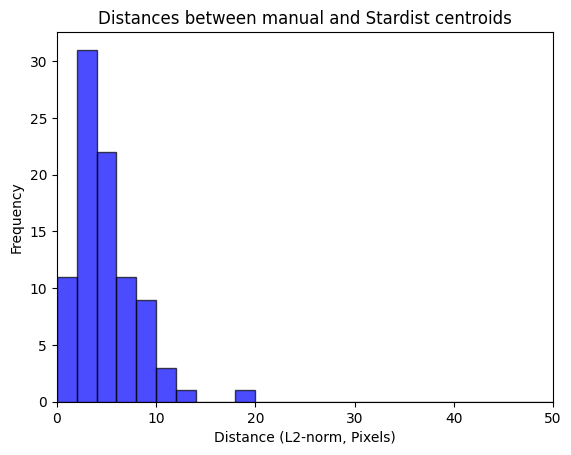

In [6]:
# Create histogram
plt.hist(dist_paolo_stardist, bins=25, range=(0, 50), color='blue', edgecolor='black', alpha=0.7)
plt.xlim(0, 50)


# Labels and title
plt.xlabel('Distance (L2-norm, Pixels)')
plt.ylabel('Frequency')
plt.title('Distances between manual and Stardist centroids')

# Show plot
plt.show()

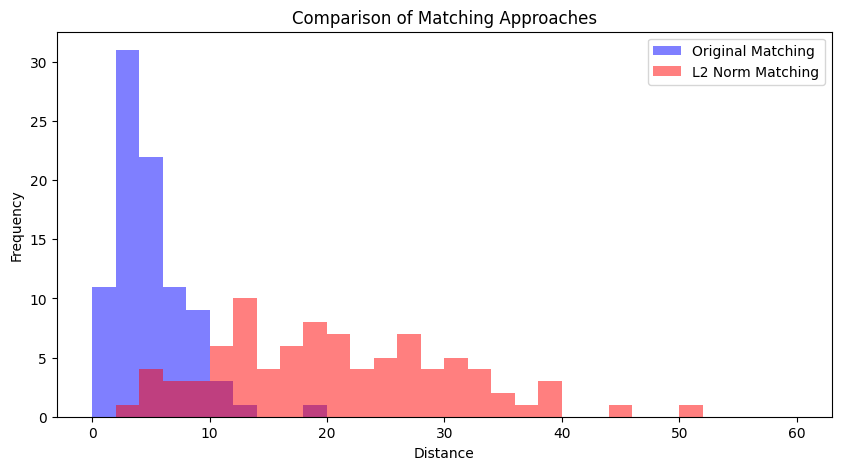

Original Matching - Mean Distance: 4.654222065130671
L2 Norm Matching - Mean Distance: 20.8033545248053
Original Matching - Median Distance: 4.123105625617661
L2 Norm Matching - Median Distance: 19.849433241279208
Original Matching - Min/Max: 1.0 / 19.4164878389476
L2 Norm Matching - Min/Max: 3.605551275463989 / 50.24937810560445


In [7]:
import matplotlib.pyplot as plt

# Ensure lists are NumPy arrays for efficient calculations
dist_paolo_stardist = np.array(dist_paolo_stardist)
dist_alt_matching = np.array(dist_alt_matching)

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(dist_paolo_stardist, bins=30, alpha=0.5, label="Original Matching", color='blue', range = (0, 60))
plt.hist(dist_alt_matching, bins=30, alpha=0.5, label="L2 Norm Matching", color='red', range = (0, 60))
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Comparison of Matching Approaches")
plt.legend()
plt.show()

# Print summary statistics
print("Original Matching - Mean Distance:", np.mean(dist_paolo_stardist))
print("L2 Norm Matching - Mean Distance:", np.mean(dist_alt_matching))
print("Original Matching - Median Distance:", np.median(dist_paolo_stardist))
print("L2 Norm Matching - Median Distance:", np.median(dist_alt_matching))
print("Original Matching - Min/Max:", np.min(dist_paolo_stardist), "/", np.max(dist_paolo_stardist))
print("L2 Norm Matching - Min/Max:", np.min(dist_alt_matching), "/", np.max(dist_alt_matching))


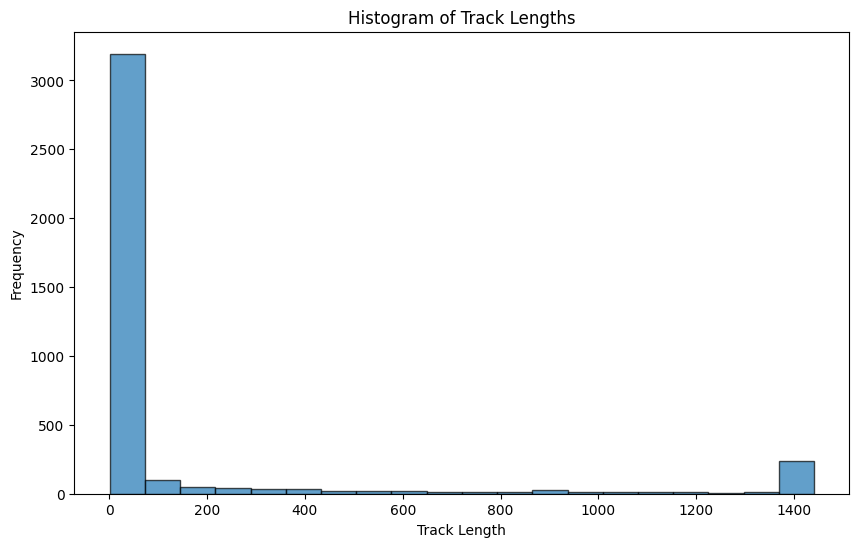

In [8]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

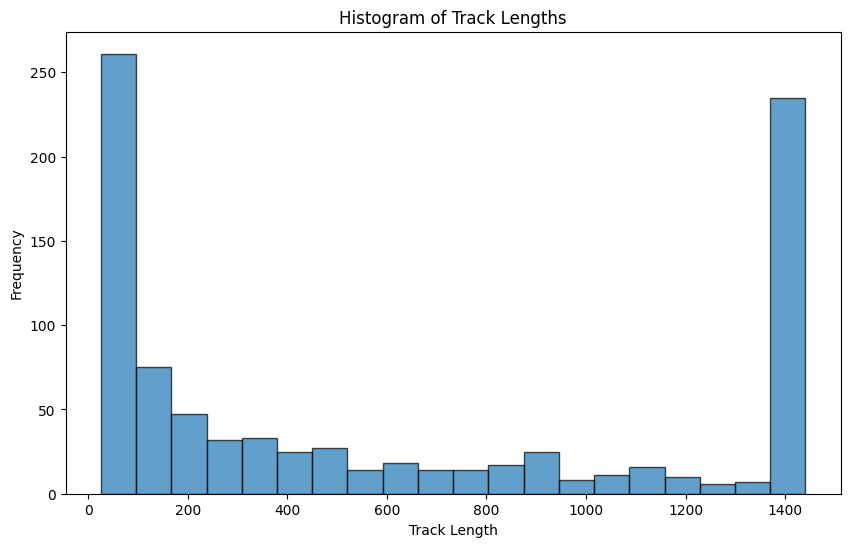

In [9]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

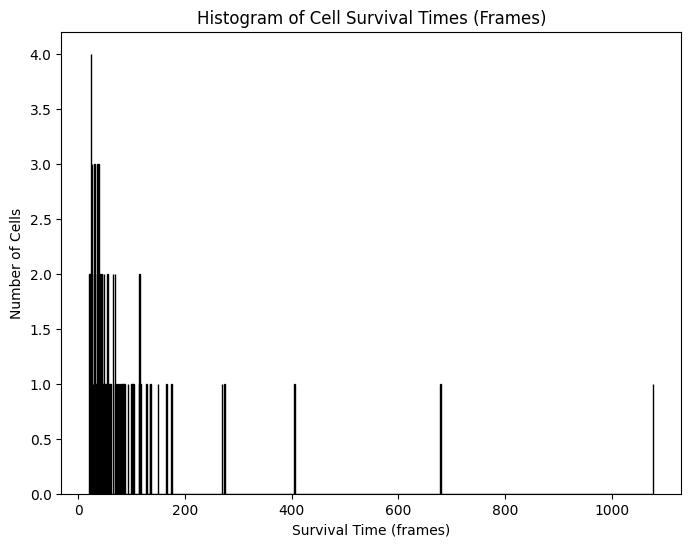

In [10]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=range(min(survival_times), max(survival_times)+2), edgecolor='black')
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

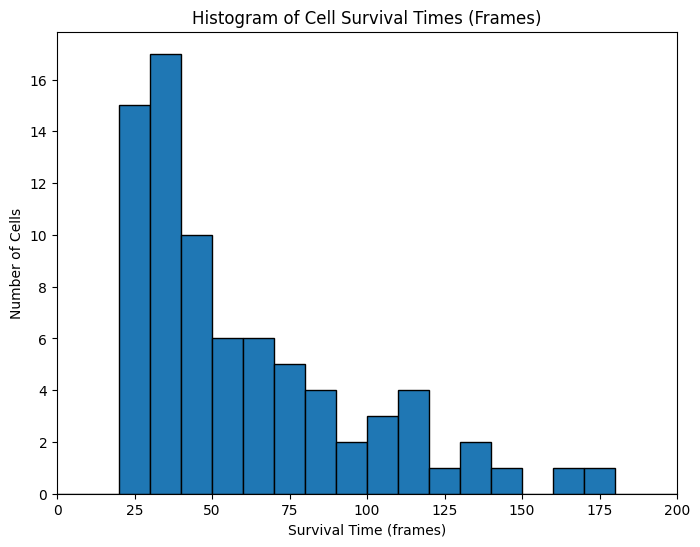

In [11]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=20, range = (0, 200), edgecolor='black')
plt.xlim(0, 200)
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

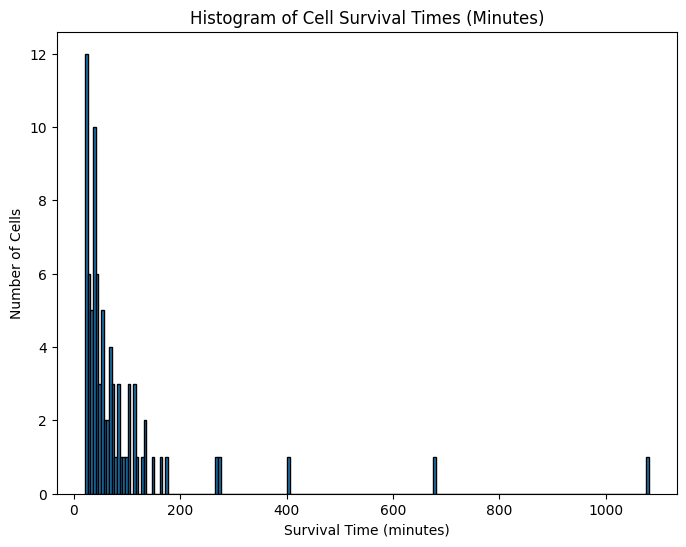

In [12]:
# Option 2: Convert survival times to minutes (if FRAME_INTERVAL is defined)
time_per_frame = 1    # One minute per frame

survival_times_minutes = [t * time_per_frame for t in survival_times]
plt.figure(figsize=(8, 6))
# Create bins with step size equal to FRAME_INTERVAL
bins = range(min(survival_times_minutes), max(survival_times_minutes) + FRAME_INTERVAL, FRAME_INTERVAL)
plt.hist(survival_times_minutes, bins=bins, edgecolor='black')
plt.xlabel("Survival Time (minutes)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Minutes)")
plt.show()

In [13]:
num_matches/(num_matches+num_mismatches)

1.0

### Plots from first approach

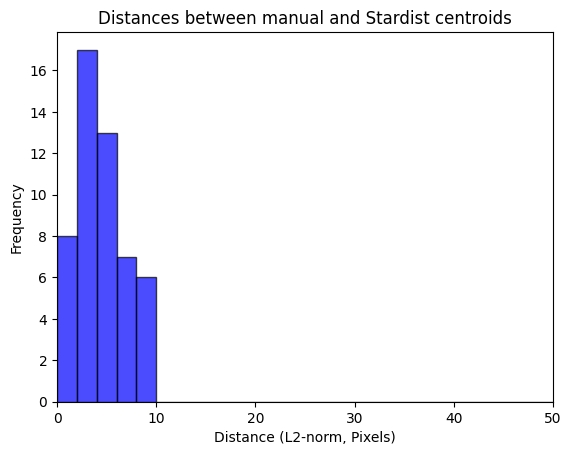

In [5]:
# Create histogram
plt.hist(dist_paolo_stardist, bins=25, range=(0, 50), color='blue', edgecolor='black', alpha=0.7)
plt.xlim(0, 50)


# Labels and title
plt.xlabel('Distance (L2-norm, Pixels)')
plt.ylabel('Frequency')
plt.title('Distances between manual and Stardist centroids')

# Show plot
plt.show()

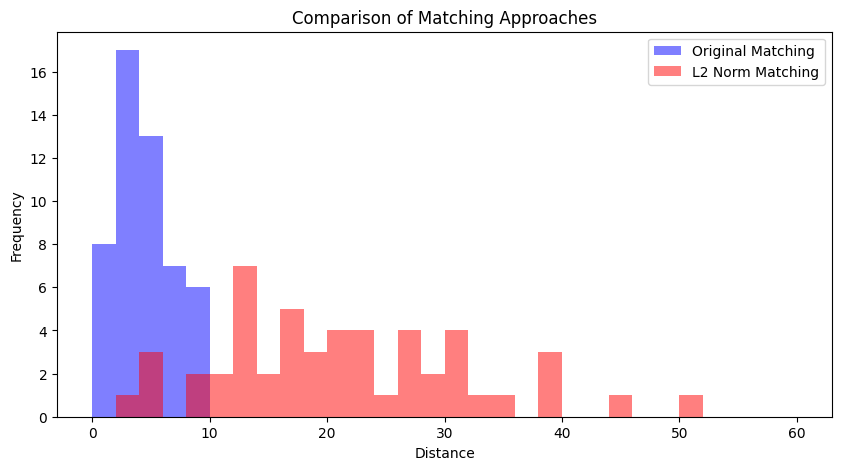

Original Matching - Mean Distance: 4.1448278829182605
L2 Norm Matching - Mean Distance: 21.339171822758782
Original Matching - Median Distance: 4.0
L2 Norm Matching - Median Distance: 20.0
Original Matching - Min/Max: 1.0 / 9.219544457292887
L2 Norm Matching - Min/Max: 3.605551275463989 / 50.24937810560445


In [6]:
import matplotlib.pyplot as plt

# Ensure lists are NumPy arrays for efficient calculations
dist_paolo_stardist = np.array(dist_paolo_stardist)
dist_alt_matching = np.array(dist_alt_matching)

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(dist_paolo_stardist, bins=30, alpha=0.5, label="Original Matching", color='blue', range = (0, 60))
plt.hist(dist_alt_matching, bins=30, alpha=0.5, label="L2 Norm Matching", color='red', range = (0, 60))
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Comparison of Matching Approaches")
plt.legend()
plt.show()

# Print summary statistics
print("Original Matching - Mean Distance:", np.mean(dist_paolo_stardist))
print("L2 Norm Matching - Mean Distance:", np.mean(dist_alt_matching))
print("Original Matching - Median Distance:", np.median(dist_paolo_stardist))
print("L2 Norm Matching - Median Distance:", np.median(dist_alt_matching))
print("Original Matching - Min/Max:", np.min(dist_paolo_stardist), "/", np.max(dist_paolo_stardist))
print("L2 Norm Matching - Min/Max:", np.min(dist_alt_matching), "/", np.max(dist_alt_matching))


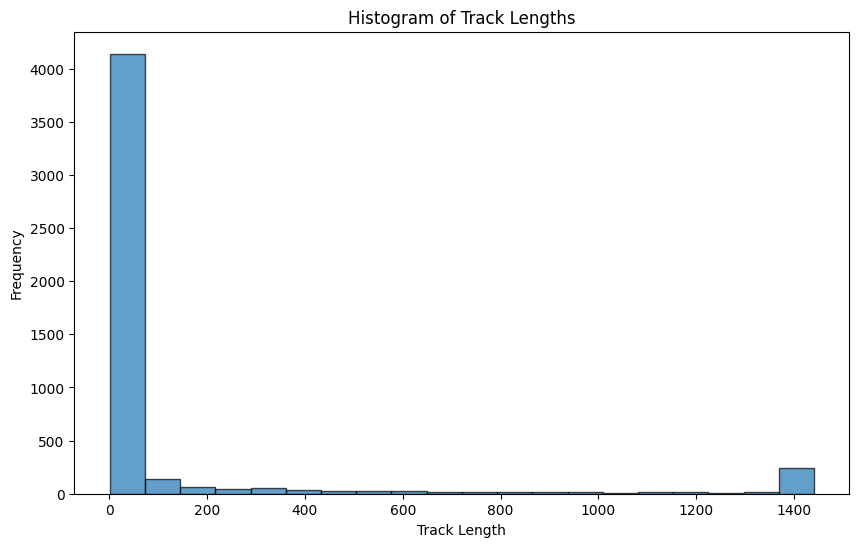

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

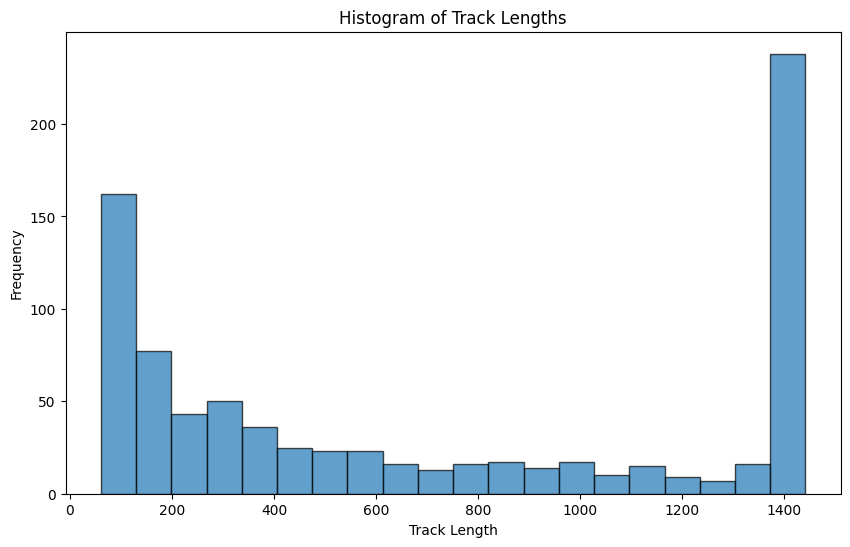

In [8]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

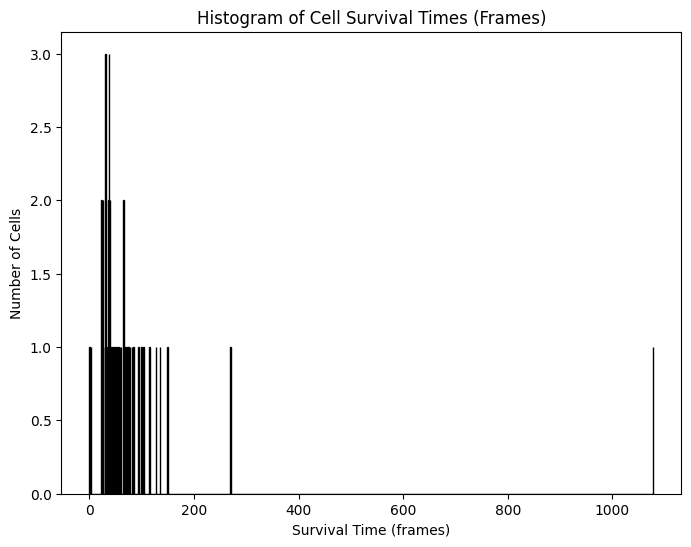

In [9]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=range(min(survival_times), max(survival_times)+2), edgecolor='black')
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

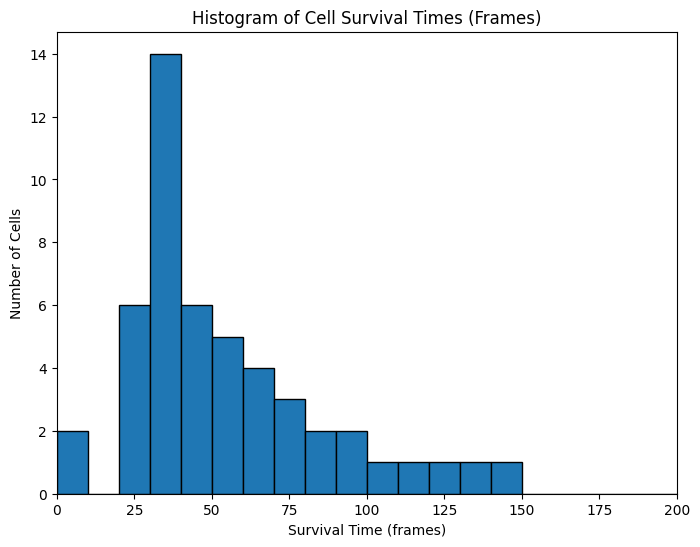

In [10]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=20, range = (0, 200), edgecolor='black')
plt.xlim(0, 200)
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

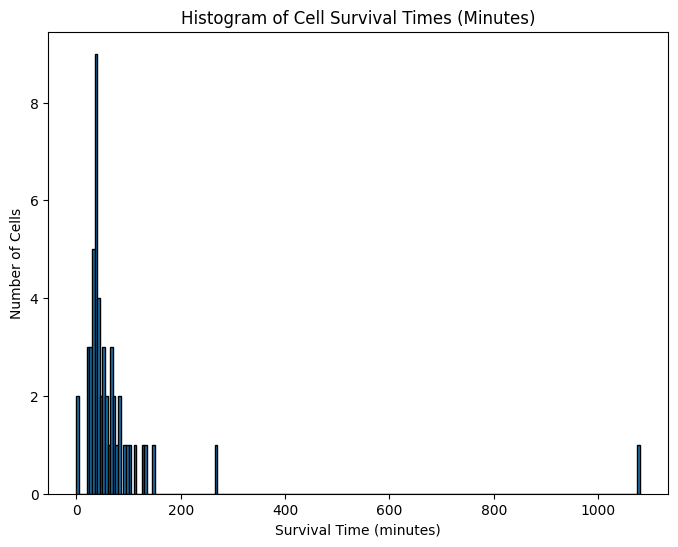

In [11]:
# Option 2: Convert survival times to minutes (if FRAME_INTERVAL is defined)
time_per_frame = 1    # One minute per frame

survival_times_minutes = [t * time_per_frame for t in survival_times]
plt.figure(figsize=(8, 6))
# Create bins with step size equal to FRAME_INTERVAL
bins = range(min(survival_times_minutes), max(survival_times_minutes) + FRAME_INTERVAL, FRAME_INTERVAL)
plt.hist(survival_times_minutes, bins=bins, edgecolor='black')
plt.xlabel("Survival Time (minutes)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Minutes)")
plt.show()

In [9]:
num_matches/(num_matches+num_mismatches)

1.0

In [10]:
num_mismatches

0